In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch 
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.datasets import fashion_mnist
from torch.utils.data import dataloader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import tensorflow as tf
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("mps")

In [3]:
(train_data,train_labels),(test_data,test_labels) = fashion_mnist.load_data()


In [4]:
train_data.shape

(60000, 28, 28)

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 1. Plotting a sample image from every class

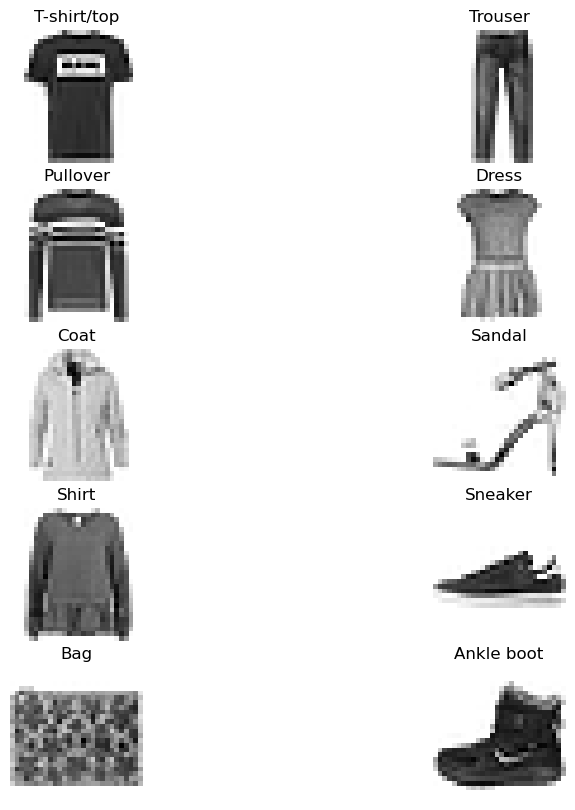

In [6]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
    # Find the first image in the training set with the corresponding label
    index = np.where(train_labels == i)[0][0]
    image = train_data[index]
    # Plot the image
    plt.subplot(5, 2, i+1)
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

# 2. Feed forward mechanism

In [10]:
def transform_data(X,y):
    X_train = X.reshape(X.shape[0],-1)
    y_train = np.zeros((y.size,y.max()+1))
    y_train[np.arange(y.size),y]=1
    return X_train,y_train    

In [11]:
X_train,y_train = transform_data(train_data,train_labels)
X_test,y_test = transform_data(test_data,test_labels)

In [12]:
mu = np.mean(X_train,axis = 0)
sigma = np.std(X_train,axis = 0)

In [13]:
X_train.shape,y_train.shape

((60000, 784), (60000, 10))

In [14]:
X_train_std = (X_train-mu)/sigma
X_test_std = (X_test-mu)/sigma

In [15]:
X_train_norm = X_train/255
X_test_norm = X_test/255

In [18]:
# custom function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x)*(1-sigmoid(x))

# define vectorized sigmoid
sigmoid_f = np.vectorize(sigmoid)
sigmoid_grad_f = np.vectorize(sigmoid_grad)


def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return (1-tanh(x)**2)

# define vectorized tanh
tanh_f = np.vectorize(tanh)
tanh_grad_f = np.vectorize(tanh_grad)

def Relu(x):
    try:
        if x>0:
            return x
        else:
            return 0
    except:
        return np.inf

        
def Relu_grad(x):
    try:
        if x>0:
            return 1
        else:
            return 0
    except:
        return np.inf
    
# define vectorized Relu
Relu_f = np.vectorize(Relu)
Relu_grad_f = np.vectorize(Relu_grad)

In [19]:
class feedforward_NN():
    def __init__(self,input_size=784,output_size=10):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = None
        self.hidden_size = None
        self.activation = None
        self.optimizer = None
        self.weight_intializer = None
        self.lamda = None
        self.epochs = None
        self.layers = [input_size]
        self.master_weights = [[0,0]]
        self.weights = []
        self.bias = []
        self.layer_outputs = []
        self.e = []
        self.d = []
        self.gprime = []
        self.del_w = []
        self.del_b = []
        self.cost_fun = []
        self.val_cost_fun = []
        self.accuracy = []
        self.val_accuracy = []
        self.last_update = []
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    def forward_prop(self,X):
        a = X.T
        self.layer_outputs = []
        self.g_prime = []
        for i in range(len(self.weights)-1):
            z = self.weights[i]@a+self.bias[i]
            #print('layer = ',i+1)
            #print('max w = ',np.round(np.max(self.weights[i]),4))
            #print('max z = ' ,np.round(np.max(z),4))
            a = self._activation(z)
            self.layer_outputs.append([z,a])
            
            g_prime = self._activation_grad(z)
            self.gprime.append(g_prime)
            
        zl = self.weights[-1]@a+self.bias[-1]
        o = self.softmax(zl)
        self.layer_outputs.append([zl,o])
        
        return o
    
    def _forward_prop(self,X):
        # doesn't updates the layer outputs and gprimes
        a = X.T
        for i in range(len(self.weights)-1):
            #print(a.shape,self.weights[i].shape,self.bias[i].shape)
            z = self.weights[i]@a+self.bias[i]
            a = self._activation(z)
            #self.layer_outputs.append([z,a])
            
            #g_prime = self._activation_grad(z)
            #self.gprime.append(g_prime)
            
        zl = self.weights[-1]@a+self.bias[-1]
        o = self.softmax(zl)
        #self.layer_outputs.append([zl,o])
        
        return o
    
        
    def back_prop(self,X,y):
        a0 = X.T
        y = y.T
        y_hat = self.layer_outputs[-1][1]
         
        self.e = []
        self.d = []
        self.del_w = []
        self.del_b = []
        
        e = -y/(y_hat+1e-8)
        d = -(y-y_hat)
        
        self.e.append(e)
        self.d.append(d)
        
        for i in range(self.hidden_layers-1,-1,-1):
            
            a_l_minus_one = self.layer_outputs[i][1]
            del_w = ((self.d[-1] @ a_l_minus_one.T)+ self.lamda*self.weights[i+1])/(self.d[-1].shape[1])
            self.del_w.append(del_w)
            
            del_b = np.mean(self.d[-1],axis=1).reshape(self.d[-1].shape[0],1)+self.lamda*self.bias[i+1]/(self.d[-1].shape[1])
            #print(del_b.shape)
            self.del_b.append(del_b)
            
            e = self.weights[i+1].T @ self.d[-1]
            self.e.append(e)
            
            g_prime = self.gprime[i]
            d = np.multiply(g_prime,self.e[-1])
            self.d.append(d)
        
        del_w = (self.d[-1] @ a0.T)/self.d[-1].shape[1] + self.lamda*self.weights[0]/self.d[-1].shape[1]
        self.del_w.append(del_w)
        
        del_b = np.mean(self.d[-1],axis = 1).reshape(self.d[-1].shape[0],1) + self.lamda*self.bias[0]/(self.d[-1].shape[1])
        self.del_b.append(del_b)
        
        self.del_w.reverse()
        self.del_b.reverse()
        

        
    
    def cost(self,X,y):
        y_true = y.T
        m = y_true.shape[1]
        #print('no of examples = ',m)
        y_hat = self._forward_prop(X)
        
        epsilon = 1e-8
        loss = np.multiply(np.log(y_hat+epsilon),y_true)
        
        cost = -np.sum(loss)/m
        
        return cost
    
    def val_accuracy(self):
        try:
            return self.val_accuracy[-1]
        except:
            return 0
    
    def _check(self,X,y):
        self.hidden_layers = 1
        self.hidden_size = 10
        for i in range(self.hidden_layers):
            self.layers.append(self.hidden_size)
        self.layers.append(self.output_size)
        
        self.activation = 'sigmoid'
        self.weight_intializer = 'Xavier'
        self._initialize_wandb(self.weight_intializer)
        self.lamda = 0
        epsilon = 1e-4
        for i in range(len(self.weights)):
            
            for j in range(len(self.weights[i])):
                
                for k in range(len(self.weights[i][j])):
                    y_hat = self.forward_prop(X)
                    self.back_prop(X,y)
                    w = self.weights[i][j][k]
                    dw = self.del_w[i][j][k]
                    
                    self.weights[i][j][k]= w + epsilon
                    Jplus = self.cost(X,y)
                    
                    self.weights[i][j][k]= w - epsilon
                    Jminus = self.cost(X,y)
                    
                    del_w = (Jplus-Jminus)/(2*epsilon)
                    
                    #print('difference = ',abs(dw-del_w))
                    if abs(dw-del_w)>epsilon:
                        print('---------------------------------')
                        print('BROKE -> ',i,' DIFFERENCE -> ',abs(dw-del_w))
                        print('---------------------------------')
                    
                    else:
                        print('passed ->',' difference -> ',abs(dw-del_w))
                    
                    self.weights[i][j][k]= w
                    
                    
        
        
    

            
    def predict(self,X):
        
        y_hat = self._forward_prop(X)
        y_hat = np.argmax(y_hat.T,axis = 1)
        
        return y_hat
        
                
                
    def print_report(self):
        print('------------------------')
        print('Model Reports')
        print('Weight initializer = ',self.weight_intializer)
        print('Optimizer = ',self.optimizer)
        print('Layer activation = ',self.activation)
        for i in range(1,len(self.weights)+1):
            print('layer = ',i,' | ', 'weights trained = ',self.weights[i-1].shape )
        try:
            print('Final validation accuracy = ',np.round(self.val_accuracy[-1],4),' Final trainig accuracy = ',np.round(self.accuracy[-1],4))
        except:
            print('empty')
        print('Total no of epochs trained = ',self.epochs)
        
    def _activation(self,z):
        
        if self.activation =='sigmoid':
            
            a = sigmoid_f(z)
            
        elif self.activation =='tanh':
            
            a = tanh_f(z)
        
        elif self.activation =='Relu':
            
            a = Relu_f(z)
        
        return a
    
    def _activation_grad(self,z):
        
        if self.activation =='sigmoid':
            
            g_prime = sigmoid_grad_f(z)
            
        elif self.activation =='tanh':
            
            g_prime = tanh_grad_f(z)
            
        elif self.activation =='Relu':
            
            g_prime = Relu_grad_f(z)
        
        return g_prime
            
    
    def _initialize_wandb(self,initializer):
        
        self.weights = []
        self.bias = []
        layers = self.layers
        for i in range(1,len(layers)):
            if initializer=='Xavier':
                #np.random.seed(42)
                w = np.random.randn(layers[i],layers[i-1])*np.sqrt(1/layers[i-1])
            elif initializer=='random':
                w = np.random.randn(layers[i],layers[i-1])
            
            elif initializer=='He':
                w = np.random.randn(layers[i],layers[i-1])*np.sqrt(2/(layers[i-1]+layers[i]))
                
            b = np.zeros((layers[i],1))
            
            self.weights.append(w)
            self.bias.append(b)
        
        

In [42]:
def train(model,X,y,hidden_layers,hidden_size,activation,weight_initialization,batch_size,optimizer,learning_rate=1e-3,lamda=0,epochs=2):

    model.hidden_layers = hidden_layers
    model.hidden_size = hidden_size

    for i in range(hidden_layers):
        model.layers.append(hidden_size)

    model.layers.append(model.output_size)

    model.weight_intializer = weight_initialization
    model._initialize_wandb(weight_initialization)

    model.activation = activation

    model.cost_fun = []
    model.val_cost_fun = []
    
    model.lamda = lamda
    
    model.optimizer = optimizer

    optim = get_optimizer(model,optimizer,learning_rate)
    #print(optim.ut[0])
    #print(model.weights[0][0][0])
    
    train_x, val_x, train_y, val_y = train_test_split(X,y,test_size=0.1,random_state=42)
    
    model.epochs = 0
    for i in range(epochs):
        
        train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
        #print(X.shape[0])
        train_dataloader = train_dataset.batch(batch_size)
        j = 1
        for X_train,y_train in train_dataloader:
            #if j==1:
             #   print(y_train[0])
              #  j+=1
            X_train,y_train = X_train.numpy(),y_train.numpy()
            
            #print(X_train.shape[0],batch_size)
            if X_train.shape[0]!=batch_size:
                #print('it ')
                continue

            #try:
            optim.update(X_train,y_train)
            
            #except:
             #   break
            
            #print(j)
            j+=1
        '''for k in range(len(model.weights)):
                print('layer = ',k)
                print('max del w = ',np.round(np.max(model.del_w[k]),4))
                print('max del b = ',np.round(np.max(model.del_b[k]),4))
                print('max  w = ',np.round(np.max(model.weights[k]),4))
                print('max  b = ',np.round(np.max(model.bias[k]),4))'''
        
        if j != len(train_dataloader):
            print('no of batches trained = ',j)
            break
        
        model.epochs+=1
        
        model.master_weights.append(model.weights)
            
        cost = model.cost(train_x,train_y)
        accuracy = accuracy_score(model.predict(train_x),np.argmax(train_y.T,axis = 0))
        
        val_cost = model.cost(val_x,val_y)
        val_accuracy = accuracy_score(model.predict(val_x),np.argmax(val_y.T,axis = 0))
        
        if i!=0 and val_cost>(model.val_cost_fun[-1]+0.1):
                break
                
        print('epochs = ',i+1 ,' | ', ' cost = ',np.round(cost,4),' | ',' val cost = ',np.round(val_cost,4),' | ',' val accuracy = ',np.round(val_accuracy,4))
        print('--------------------')
        
        model.cost_fun.append(cost)
        model.accuracy.append(accuracy)
        
        model.val_cost_fun.append(val_cost)
        model.val_accuracy.append(val_accuracy)
        
        
        
    model.print_report()

In [21]:
def get_optimizer(model,optimizer,learning_rate):
        
    if optimizer == 'sgd':
        optim = SGD(model,learning_rate)

    elif optimizer == 'momentum':
        #print('it came here')
        optim = Momentum(model,learning_rate)

    elif optimizer == 'nag':
        optim = NAG(model,learning_rate)

    elif optimizer == 'rmsprop':
        optim = RMSProp(model,learning_rate)

    elif optimizer == 'adam':
        optim = Adam(model,learning_rate)

    elif optimizer == 'nadam':
        optim = NAdam(model,learning_rate)

    return optim

In [22]:
class SGD():
    
    def __init__(self,model,learning_rate):
        self.model = model
        self.learning_rate = learning_rate
    
    def update(self,X_train,y_train):
        
        y_hat = self.model.forward_prop(X_train)
        
        self.model.back_prop(X_train,y_train)
        #print(self.model.del_b[0].shape)
        
        for i in range(len(self.model.weights)):
        
            self.model.weights[i] = self.model.weights[i] - self.learning_rate*self.model.del_w[i]
            
            self.model.bias[i] = self.model.bias[i] - self.learning_rate*self.model.del_b[i]
        
        
class Momentum():
    
    def __init__(self,model,learning_rate,beta=0.9):
        
        self.model = model
        
        self.learning_rate = learning_rate
        self.beta = beta
        
        self.ut = []
        self.bt = []
        
        for i in range(len(self.model.weights)):
            
            ut = np.zeros(self.model.weights[i].shape)
            self.ut.append(ut)
            
            bt = np.zeros(self.model.bias[i].shape)
            self.bt.append(bt)
            
    
    def update(self,X_train,y_train):
        #print(self.ut[0][0][0])
        #Propogating forward and collecting output of every layer and gradients of activations
        #print('came here')
        y_hat = self.model.forward_prop(X_train)
        
        #Back propogating and collecting gradient for every weight matrix 
        self.model.back_prop(X_train,y_train)
        
        for i in range(len(self.model.weights)):
            #print('came here also')
            #print('max del_w ',np.round(np.max(self.model.del_w[i]),4))
            ut = self.beta*self.ut[i] + self.model.del_w[i]
            self.model.weights[i] = self.model.weights[i] - self.learning_rate*ut
            #if i==0:
                #print('layer = ',i,' norm = ',np.linalg.norm(self.ut[i]-ut))
            self.ut[i] = ut
            
            bt = self.beta*self.bt[i] + self.model.del_b[i]
            self.model.bias[i] = self.model.bias[i] - self.learning_rate*bt
            self.bt[i] = bt
        

class NAG():
    
    def __init__(self,model,learning_rate,beta=0.9):
        self.model = model
        
        self.learning_rate = learning_rate
        self.beta = beta
        
        self.ut = []
        self.bt = []
        
        for i in range(len(self.model.weights)):
            
            ut = np.zeros(self.model.weights[i].shape)
            self.ut.append(ut)
            
            bt = np.zeros(self.model.bias[i].shape)
            self.bt.append(bt)
    
    def update(self,X_train,y_train):
        
        #y_hat = self.model.forward_prop(X_train)
        weights = []
        bias = []
        for i in range(len(self.model.weights)):
            weights.append(self.model.weights[i])
            self.model.weights[i] = self.model.weights[i] - self.beta*self.ut[i]
            
            bias.append(self.model.bias[i])
            self.model.bias[i] = self.model.bias[i] - self.beta*self.bt[i]
        
        y_hat = self.model.forward_prop(X_train)
        
        self.model.back_prop(X_train,y_train)
        
        for i in range(len(self.model.weights)):
            
            ut = self.beta*self.ut[i] + self.model.del_w[i]
            #self.model.weights[i] = self.model.weights[i] + self.beta*self.ut[i]
            self.model.weights[i] = weights[i] - self.learning_rate*ut
            self.ut[i] = ut
            
            bt = self.beta*self.bt[i] + self.model.del_b[i]
            #self.model.bias[i] = self.model.bias[i] + self.beta*self.bt[i]
            self.model.bias[i] = bias[i] - self.learning_rate*bt
            self.bt[i] = bt
        
        
class RMSProp():
    
    def __init__(self,model,learning_rate,beta=0.9):
        self.model = model
        
        self.learning_rate = learning_rate
        self.beta = beta
        
        self.ut = []
        self.bt = []
        
        for i in range(len(self.model.weights)):
            
            ut = np.zeros(self.model.weights[i].shape)
            self.ut.append(ut)
            
            bt = np.zeros(self.model.bias[i].shape)
            self.bt.append(bt)
    
    def update(self,X_train,y_train):
        
        y_hat = self.model.forward_prop(X_train)
        
        epsilon = 1e-5
        #Back propogating and collecting gradient for every weight matrix 
        self.model.back_prop(X_train,y_train)
        
        for i in range(len(self.model.weights)):
            #print('came here also')
            #print('max del_w ',np.round(np.max(self.model.del_w[i]),4))
            ut = self.beta*self.ut[i] + (1-self.beta)*(self.model.del_w[i]**2)
            self.model.weights[i] = self.model.weights[i] - (self.learning_rate/(np.sqrt(ut)+epsilon))*(self.model.del_w[i])
            #if i==0:
                #print('layer = ',i,' norm = ',np.linalg.norm(self.ut[i]-ut))
            self.ut[i] = ut
            
            bt = self.beta*self.bt[i] + (1-self.beta)*(self.model.del_b[i]**2)
            self.model.bias[i] = self.model.bias[i] - (self.learning_rate/(np.sqrt(bt)+epsilon))*self.model.del_b[i]
            self.bt[i] = bt
        
        
        
class Adam():
    
    def __init__(self,model,learning_rate,beta1=0.9,beta2=0.99):
        
        self.model = model
        
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        
        self.mt = []
        self.vt = []
        
        self.mbt = []
        self.vbt = []
        
        self.t = 1
        
        for i in range(len(self.model.weights)):
            
            mt = np.zeros(self.model.weights[i].shape)
            vt = np.zeros(self.model.weights[i].shape)
            self.mt.append(mt)
            self.vt.append(vt)
            
            mbt = np.zeros(self.model.bias[i].shape)
            vbt = np.zeros(self.model.bias[i].shape)
            self.mbt.append(mbt)
            self.vbt.append(vbt)
    
    def update(self,X_train,y_train):
        
        y_hat = self.model.forward_prop(X_train)
        
        self.model.back_prop(X_train,y_train)
        
        epsilon = 1e-8
        
        for i in range(len(self.model.weights)):
            
            mt = self.beta1*self.mt[i] + (1-self.beta1)*(self.model.del_w[i])
            mt_hat = mt/(1-np.power(self.beta1,self.t))
            
            vt = self.beta2*self.vt[i] + (1-self.beta2)*np.power(self.model.del_w[i],2)
            vt_hat = vt/(1-np.power(self.beta2,self.t))

            self.model.weights[i] = self.model.weights[i] - self.learning_rate*mt_hat/(np.sqrt(vt_hat)+epsilon)
            
            self.mt[i] = mt
            self.vt[i] = vt
            
            mbt = self.beta1*self.mbt[i] + (1-self.beta1)*self.model.del_b[i]
            mbt_hat = mbt/(1-np.power(self.beta1,self.t))
            
            vbt = self.beta2*self.vbt[i] + (1-self.beta2)*np.power(self.model.del_b[i],2)
            vbt_hat = vbt/(1-np.power(self.beta2,self.t))
            
            self.model.bias[i] = self.model.bias[i] - self.learning_rate*mbt_hat/(np.sqrt(vbt_hat)+epsilon)
            
            self.mbt[i] = mbt
            self.vbt[i] = vbt
        
        self.t+=1
        
        
        
class NAdam():
    
    def __init__(self,model,learning_rate,beta1=0.9,beta2=0.99):
        
        self.model = model
        
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        
        self.mt = []
        self.vt = []
        
        self.mbt = []
        self.vbt = []
        
        self.t = 1
        
        for i in range(len(self.model.weights)):
            
            mt = np.zeros(self.model.weights[i].shape)
            vt = np.zeros(self.model.weights[i].shape)
            self.mt.append(mt)
            self.vt.append(vt)
            
            mbt = np.zeros(self.model.bias[i].shape)
            vbt = np.zeros(self.model.bias[i].shape)
            self.mbt.append(mbt)
            self.vbt.append(vbt)
        
    
    def update(self,X_train,y_train):
        
        y_hat = self.model.forward_prop(X_train)
        
        self.model.back_prop(X_train,y_train)
        
        epsilon = 1e-8
        
        beta1 = self.beta1
        
        beta2 = self.beta2
        
        for i in range(len(self.model.weights)):

            mt = beta1*self.mt[i] + (1-beta1)*self.model.del_w[i]
            mt_hat = mt/(1-np.power(beta1,self.t))
            
            #print(self.vt[i].shape,self.model.del_w[i].shape)
            vt = beta2*self.vt[i] + (1-beta2)*np.power(self.model.del_w[i],2)
            vt_hat = vt/(1-np.power(beta2,self.t))
            

            numerator = (beta1*mt_hat) + (1-beta1)*self.model.del_w[i]/(1-np.power(beta1,self.t))
            denominator = np.sqrt(vt_hat)+epsilon

            self.model.weights[i] = self.model.weights[i] - (self.learning_rate*numerator)/(denominator)

            self.mt[i] = mt
            self.vt[i] = vt

            mbt = beta1*self.mbt[i] + (1-beta1)*self.model.del_b[i]
            mbt_hat = mbt/(1-np.power(beta1,self.t))
            

            vbt = beta2*self.vbt[i] + (1-self.beta2)*np.power(self.model.del_b[i],2)
            vbt_hat = vbt/(1-np.power(beta2,self.t))

            numerator = (beta1*mbt_hat) + (1-beta1)*self.model.del_b[i]/(1-np.power(beta1,self.t))
            denominator = np.sqrt(vbt_hat)+epsilon

            self.model.bias[i] = self.model.bias[i] - (self.learning_rate*numerator)/(denominator)

            self.mbt[i] = mbt
            self.vbt[i] = vbt

        self.t+=1
        
        
            

In [23]:
import wandb

wandb.login()
#!wandb login --relogin

wandb: Currently logged in as: uttakarsh05 (fodl-assignment). Use `wandb login --relogin` to force relogin


True

In [24]:
sweep_config = {
    'method': 'bayes'
    }
metric = {
    'name': 'val_accuracy',
    'goal': 'maximize'   
    }
sweep_config['metric'] = metric

In [25]:
parameters_dict = {
    'optimizer': {
        'values': ['adam','nadam','rmsprop','nag','sgd']
        },
    'hidden_size': {
        'values': [64,128]
        },
    'hidden_layers': {
          'values': [3]
        },
    'activation':{
        'values': ['Relu','tanh']
        },
    'weight_initialization':{
        'values': ['Xavier','He']
        },
    'batch_size':{
        'values': [16,32,64]
        },
    'learning_rate':{
        'values': [1e-3,1e-4]
        },
    'lamda':{
        'values': [0, 0.0005]
        },
    'epochs':{
        'values': [5,10]
        }
    
    }

sweep_config['parameters'] = parameters_dict

In [28]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'activation': {'values': ['Relu', 'tanh']},
                'batch_size': {'values': [16, 32, 64]},
                'epochs': {'values': [5, 10]},
                'hidden_layers': {'values': [3]},
                'hidden_size': {'values': [64, 128]},
                'lamda': {'values': [0, 0.0005]},
                'learning_rate': {'values': [0.001, 0.0001]},
                'optimizer': {'values': ['adam',
                                         'nadam',
                                         'rmsprop',
                                         'nag',
                                         'sgd']},
                'weight_initialization': {'values': ['Xavier', 'He']}}}


In [29]:
sweep_id = wandb.sweep(sweep_config, project='He_Xavier_tanh_relu_32_sgd_updated')

Create sweep with ID: a50do5j8
Sweep URL: https://wandb.ai/fodl-assignment/He_Xavier_tanh_relu_32_sgd_updated/sweeps/a50do5j8


In [30]:
X = X_train_std
y = y_train

In [39]:
def train_wandb(config = None):
    print(config)
    with wandb.init(config=config):
        
        #wandb.init(name=config.activation+'-'+'bs-'+str(batch_size)+'-'+'h_l-'+str(config.hidden_layers)+'-'+'h_s-'+str(config.hidden_size)+'-'+'epoch-'+str(config.epochs)+'-'+'lamda-'+str(config.lamda)+'-'+'lr-'+str(config.learning_rate)+'-'+config.optimizer+'-'+config.weight_initialization)
        
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
    
        input_size,output_size = 28*28,10
        model = feedforward_NN(input_size,output_size)

        model.hidden_layers = config.hidden_layers
        model.hidden_size = config.hidden_size

        for i in range(config.hidden_layers):
            model.layers.append(config.hidden_size)

        model.layers.append(model.output_size)

        model.weight_intializer = config.weight_initialization
        model._initialize_wandb(config.weight_initialization)

        model.activation = config.activation

        model.cost_fun = []
        model.val_cost_fun = []

        model.lamda = config.lamda

        model.optimizer = config.optimizer

        optim = get_optimizer(model,model.optimizer,config.learning_rate)
        #print(optim.ut[0])
        #print(model.weights[0][0][0])

        train_x, val_x, train_y, val_y = train_test_split(X,y,test_size=0.1,random_state=42)

        batch_size = config.batch_size

        if config.optimizer=='sgd':
            batch_size = 1

        model.epochs = 0
        for i in range(config.epochs):

            train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
            #print(X.shape[0])
            train_dataloader = train_dataset.batch(batch_size)
            j = 1
            for X_train,y_train in train_dataloader:
                #if j==1:
                 #   print(y_train[0])
                  #  j+=1
                X_train,y_train = X_train.numpy(),y_train.numpy()

                #print(X_train.shape[0],batch_size)
                if X_train.shape[0]!=batch_size:
                    #print('it ')
                    continue

                try:
                    optim.update(X_train,y_train)

                except:
                    wandb.log({'epochs':i+1 ,'val_accuracy':0})
                    break
                    
                 #   break

                #print(j)
                j+=1
            '''for k in range(len(model.weights)):
                    print('layer = ',k)
                    print('max del w = ',np.round(np.max(model.del_w[k]),4))
                    print('max del b = ',np.round(np.max(model.del_b[k]),4))
                    print('max  w = ',np.round(np.max(model.weights[k]),4))
                    print('max  b = ',np.round(np.max(model.bias[k]),4))'''

            if j != len(train_dataloader):
                print('no of batches trained = ',j)
                try:
                    wandb.log({'epochs':i+1 ,'val_accuracy':val_accuracy})
                except:
                    wandb.log({'epochs':i+1 ,'val_accuracy':0})
                    
                #print('--------------------')
                break

            model.epochs+=1

            model.master_weights.append(model.weights)
    
            cost = model.cost(train_x,train_y)
            accuracy = accuracy_score(model.predict(train_x),np.argmax(train_y.T,axis = 0))

            val_cost = model.cost(val_x,val_y)
            val_accuracy = accuracy_score(model.predict(val_x),np.argmax(val_y.T,axis = 0))

            
            print('epochs = ',i+1 ,' | ', ' cost = ',np.round(cost,4),' | ',' val cost = ',np.round(val_cost,4),' | ',' val accuracy = ',np.round(val_accuracy,4)*100)
            print('--------------------')
            wandb.log({'epochs':i+1 , 'train cost':np.round(cost,4),'val cost':np.round(val_cost,4),'train accuracy ':np.round(accuracy,4)*100,'val_accuracy':np.round(val_accuracy,4)*100})
            #print('--------------------')
            
            if cost>0.9:
                break
            if i!=0 and val_cost>(model.val_cost_fun[-1]+0.1):
                    break

            model.cost_fun.append(cost)
            model.accuracy.append(accuracy)

            model.val_cost_fun.append(val_cost)
            model.val_accuracy.append(val_accuracy)



        model.print_report()

In [25]:
wandb.agent(sweep_id, train_wandb, count=32)

wandb: Agent Starting Run: u28stvvp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_initialization: Xavier


2023-03-08 18:58:09.764130: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 18:58:09.764161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
no of batches trained =  54001
------------------------
Model Reports
Weight initializer =  Xavier
Optimizer =  sgd
Layer activation =  tanh
layer =  1  |  weights trained =  (128, 784)
layer =  2  |  weights trained =  (128, 128)
layer =  3  |  weights trained =  (128, 128)
layer =  4  |  weights trained =  (10, 128)
empty
Total no of epochs trained =  0


epochs,▁
val_accuracy,▁
epochs,1
val_accuracy,0


wandb: Agent Starting Run: dtcrrkka with config:
wandb: 	activation: Relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_initialization: He


no of batches trained =  10
------------------------
Model Reports
Weight initializer =  He
Optimizer =  nag
Layer activation =  Relu
layer =  1  |  weights trained =  (128, 784)
layer =  2  |  weights trained =  (128, 128)
layer =  3  |  weights trained =  (128, 128)
layer =  4  |  weights trained =  (10, 128)
empty
Total no of epochs trained =  0


epochs,▁▁
val_accuracy,▁▁
epochs,1
val_accuracy,0


wandb: Agent Starting Run: f93w3fbz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_initialization: Xavier


epochs =  1  |   cost =  0.503  |   val cost =  0.5083  |   val accuracy =  81.77
--------------------
epochs =  2  |   cost =  0.4558  |   val cost =  0.4636  |   val accuracy =  83.53
--------------------
epochs =  3  |   cost =  0.4358  |   val cost =  0.445  |   val accuracy =  84.22
--------------------
epochs =  4  |   cost =  0.4246  |   val cost =  0.4354  |   val accuracy =  84.5
--------------------
epochs =  5  |   cost =  0.4171  |   val cost =  0.4293  |   val accuracy =  84.61999999999999
--------------------
epochs =  6  |   cost =  0.4121  |   val cost =  0.4257  |   val accuracy =  84.82
--------------------
epochs =  7  |   cost =  0.4085  |   val cost =  0.4245  |   val accuracy =  84.92
--------------------
epochs =  8  |   cost =  0.4053  |   val cost =  0.4233  |   val accuracy =  84.89999999999999
--------------------
epochs =  9  |   cost =  0.4025  |   val cost =  0.4216  |   val accuracy =  84.77
--------------------
epochs =  10  |   cost =  0.3998  |   val c

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▇▇▇████
train cost,█▅▃▃▂▂▂▁▁▁
val cost,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇█████
epochs,10
train accuracy,85.9
train cost,0.3998
val cost,0.4197
val_accuracy,84.8


wandb: Agent Starting Run: ilea07gz with config:
wandb: 	activation: Relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.5419  |   val cost =  0.5574  |   val accuracy =  79.53
--------------------
epochs =  2  |   cost =  0.481  |   val cost =  0.5018  |   val accuracy =  81.95
--------------------
epochs =  3  |   cost =  0.4522  |   val cost =  0.4696  |   val accuracy =  82.97
--------------------
epochs =  4  |   cost =  0.4396  |   val cost =  0.4574  |   val accuracy =  83.33
--------------------
epochs =  5  |   cost =  0.4364  |   val cost =  0.4552  |   val accuracy =  83.55
--------------------
epochs =  6  |   cost =  0.4333  |   val cost =  0.4536  |   val accuracy =  84.28
--------------------
epochs =  7  |   cost =  0.4354  |   val cost =  0.4613  |   val accuracy =  84.07
--------------------
epochs =  8  |   cost =  0.4356  |   val cost =  0.4596  |   val accuracy =  84.1
--------------------
epochs =  9  |   cost =  0.4399  |   val cost =  0.4649  |   val accuracy =  84.6
--------------------
epochs =  10  |   cost =  0.4545  |   val cost =  0.479  |   val ac

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▅▆▇▇████▇
train cost,█▄▂▁▁▁▁▁▁▂
val cost,█▄▂▁▁▁▂▁▂▃
val_accuracy,▁▄▆▆▇█▇▇█▇
epochs,10
train accuracy,84.75
train cost,0.4545
val cost,0.479
val_accuracy,84.2


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: il09zyrz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_initialization: He


no of batches trained =  54001
------------------------
Model Reports
Weight initializer =  He
Optimizer =  sgd
Layer activation =  tanh
layer =  1  |  weights trained =  (128, 784)
layer =  2  |  weights trained =  (128, 128)
layer =  3  |  weights trained =  (128, 128)
layer =  4  |  weights trained =  (10, 128)
empty
Total no of epochs trained =  0


epochs,▁
val_accuracy,▁
epochs,1
val_accuracy,0


wandb: Agent Starting Run: oc9233zy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.487  |   val cost =  0.4919  |   val accuracy =  82.08
--------------------
epochs =  2  |   cost =  0.4472  |   val cost =  0.4565  |   val accuracy =  83.5
--------------------
epochs =  3  |   cost =  0.4293  |   val cost =  0.4416  |   val accuracy =  84.07
--------------------
epochs =  4  |   cost =  0.4196  |   val cost =  0.4343  |   val accuracy =  84.43
--------------------
epochs =  5  |   cost =  0.4143  |   val cost =  0.4308  |   val accuracy =  84.47
--------------------
epochs =  6  |   cost =  0.4102  |   val cost =  0.4281  |   val accuracy =  84.72
--------------------
epochs =  7  |   cost =  0.4067  |   val cost =  0.4253  |   val accuracy =  84.83000000000001
--------------------
epochs =  8  |   cost =  0.4045  |   val cost =  0.4229  |   val accuracy =  85.1
--------------------
epochs =  9  |   cost =  0.4038  |   val cost =  0.4221  |   val accuracy =  85.22
--------------------
epochs =  10  |   cost =  0.4039  |   val cost =  0.422

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▇▇▇████
train cost,█▅▃▂▂▂▁▁▁▁
val cost,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
epochs,10
train accuracy,85.74
train cost,0.4039
val cost,0.4225
val_accuracy,85.3


wandb: Agent Starting Run: znhmtg61 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.48  |   val cost =  0.4855  |   val accuracy =  82.45
--------------------
epochs =  2  |   cost =  0.4414  |   val cost =  0.4522  |   val accuracy =  83.65
--------------------
epochs =  3  |   cost =  0.4237  |   val cost =  0.4364  |   val accuracy =  84.48
--------------------
epochs =  4  |   cost =  0.4122  |   val cost =  0.4257  |   val accuracy =  85.0
--------------------
epochs =  5  |   cost =  0.4043  |   val cost =  0.4194  |   val accuracy =  85.27
--------------------
epochs =  6  |   cost =  0.3992  |   val cost =  0.4168  |   val accuracy =  85.17
--------------------
epochs =  7  |   cost =  0.3957  |   val cost =  0.416  |   val accuracy =  85.22
--------------------
epochs =  8  |   cost =  0.3938  |   val cost =  0.4166  |   val accuracy =  85.11999999999999
--------------------
epochs =  9  |   cost =  0.393  |   val cost =  0.4177  |   val accuracy =  84.87
--------------------
epochs =  10  |   cost =  0.3929  |   val cost =  0.4195 

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▆▇█████
train cost,█▅▃▃▂▂▁▁▁▁
val cost,█▅▃▂▁▁▁▁▁▁
val_accuracy,▁▄▆▇████▇▇
epochs,10
train accuracy,86.21
train cost,0.3929
val cost,0.4195
val_accuracy,84.88


wandb: Agent Starting Run: adoe8ze6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.4893  |   val cost =  0.4984  |   val accuracy =  82.0
--------------------
epochs =  2  |   cost =  0.4472  |   val cost =  0.4567  |   val accuracy =  83.53
--------------------
epochs =  3  |   cost =  0.4302  |   val cost =  0.4394  |   val accuracy =  84.28
--------------------
epochs =  4  |   cost =  0.4201  |   val cost =  0.4306  |   val accuracy =  84.53
--------------------
epochs =  5  |   cost =  0.4133  |   val cost =  0.4271  |   val accuracy =  84.55
--------------------
epochs =  6  |   cost =  0.4093  |   val cost =  0.425  |   val accuracy =  84.32
--------------------
epochs =  7  |   cost =  0.4062  |   val cost =  0.4225  |   val accuracy =  84.7
--------------------
epochs =  8  |   cost =  0.4026  |   val cost =  0.4183  |   val accuracy =  84.88
--------------------
epochs =  9  |   cost =  0.3987  |   val cost =  0.4135  |   val accuracy =  85.28
--------------------
epochs =  10  |   cost =  0.3952  |   val cost =  0.4089  |   val a

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▅▆▇▇▇▇██
train cost,█▅▄▃▂▂▂▂▁▁
val cost,█▅▃▃▂▂▂▂▁▁
val_accuracy,▁▄▆▆▆▆▇▇██
epochs,10
train accuracy,86.27
train cost,0.3952
val cost,0.4089
val_accuracy,85.38


wandb: Agent Starting Run: wo31rxtx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.5025  |   val cost =  0.5116  |   val accuracy =  81.37
--------------------
epochs =  2  |   cost =  0.4521  |   val cost =  0.4612  |   val accuracy =  83.22
--------------------
epochs =  3  |   cost =  0.4308  |   val cost =  0.4405  |   val accuracy =  84.05
--------------------
epochs =  4  |   cost =  0.4177  |   val cost =  0.4293  |   val accuracy =  84.55
--------------------
epochs =  5  |   cost =  0.409  |   val cost =  0.4231  |   val accuracy =  85.0
--------------------
epochs =  6  |   cost =  0.403  |   val cost =  0.4196  |   val accuracy =  85.42999999999999
--------------------
epochs =  7  |   cost =  0.3988  |   val cost =  0.4175  |   val accuracy =  85.55
--------------------
epochs =  8  |   cost =  0.3959  |   val cost =  0.4163  |   val accuracy =  85.33
--------------------
epochs =  9  |   cost =  0.3938  |   val cost =  0.4159  |   val accuracy =  85.28
--------------------
epochs =  10  |   cost =  0.3925  |   val cost =  0.415

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▅▆▇▇▇███
train cost,█▅▃▃▂▂▁▁▁▁
val cost,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇█████
epochs,10
train accuracy,86.35
train cost,0.3925
val cost,0.4159
val_accuracy,85.58


wandb: Agent Starting Run: 82v1du17 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: Xavier


epochs =  1  |   cost =  0.5243  |   val cost =  0.5268  |   val accuracy =  81.17
--------------------
epochs =  2  |   cost =  0.4659  |   val cost =  0.4695  |   val accuracy =  83.08
--------------------
epochs =  3  |   cost =  0.4435  |   val cost =  0.4488  |   val accuracy =  83.7
--------------------
epochs =  4  |   cost =  0.4304  |   val cost =  0.4386  |   val accuracy =  83.8
--------------------
epochs =  5  |   cost =  0.4212  |   val cost =  0.4323  |   val accuracy =  84.25
--------------------
epochs =  6  |   cost =  0.4142  |   val cost =  0.4277  |   val accuracy =  84.38
--------------------
epochs =  7  |   cost =  0.4087  |   val cost =  0.4243  |   val accuracy =  84.6
--------------------
epochs =  8  |   cost =  0.4041  |   val cost =  0.4214  |   val accuracy =  84.82
--------------------
epochs =  9  |   cost =  0.4004  |   val cost =  0.4188  |   val accuracy =  84.97
--------------------
epochs =  10  |   cost =  0.3975  |   val cost =  0.4165  |   val a

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▅▆▇▇▇███
train cost,█▅▄▃▂▂▂▁▁▁
val cost,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
epochs,10
train accuracy,86.15
train cost,0.3975
val cost,0.4165
val_accuracy,85.08


wandb: Agent Starting Run: x3l2as7e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.5199  |   val cost =  0.5243  |   val accuracy =  81.27
--------------------
epochs =  2  |   cost =  0.4695  |   val cost =  0.4752  |   val accuracy =  82.97
--------------------
epochs =  3  |   cost =  0.4493  |   val cost =  0.4555  |   val accuracy =  83.8
--------------------
epochs =  4  |   cost =  0.4379  |   val cost =  0.4446  |   val accuracy =  84.28
--------------------
epochs =  5  |   cost =  0.4303  |   val cost =  0.4382  |   val accuracy =  84.45
--------------------
epochs =  6  |   cost =  0.4246  |   val cost =  0.4337  |   val accuracy =  84.57000000000001
--------------------
epochs =  7  |   cost =  0.42  |   val cost =  0.4306  |   val accuracy =  84.58
--------------------
epochs =  8  |   cost =  0.4161  |   val cost =  0.4284  |   val accuracy =  84.75
--------------------
epochs =  9  |   cost =  0.4127  |   val cost =  0.4268  |   val accuracy =  84.89999999999999
--------------------
epochs =  10  |   cost =  0.4096  |   val c

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▆▇▇████
train cost,█▅▄▃▂▂▂▁▁▁
val cost,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
epochs,10
train accuracy,85.62
train cost,0.4096
val cost,0.4255
val_accuracy,84.88


wandb: Agent Starting Run: wwzo8qce with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: Xavier


epochs =  1  |   cost =  0.5524  |   val cost =  0.5598  |   val accuracy =  79.7
--------------------
epochs =  2  |   cost =  0.4843  |   val cost =  0.4938  |   val accuracy =  82.45
--------------------
epochs =  3  |   cost =  0.4555  |   val cost =  0.4659  |   val accuracy =  83.53
--------------------
epochs =  4  |   cost =  0.439  |   val cost =  0.4502  |   val accuracy =  84.25
--------------------
epochs =  5  |   cost =  0.4287  |   val cost =  0.4407  |   val accuracy =  84.6
--------------------
epochs =  6  |   cost =  0.4218  |   val cost =  0.4341  |   val accuracy =  84.93
--------------------
epochs =  7  |   cost =  0.4168  |   val cost =  0.4292  |   val accuracy =  85.03
--------------------
epochs =  8  |   cost =  0.4127  |   val cost =  0.4254  |   val accuracy =  85.13
--------------------
epochs =  9  |   cost =  0.409  |   val cost =  0.4221  |   val accuracy =  85.0
--------------------
epochs =  10  |   cost =  0.4054  |   val cost =  0.4191  |   val acc

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▇▇▇████
train cost,█▅▃▃▂▂▂▁▁▁
val cost,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇█████
epochs,10
train accuracy,85.69
train cost,0.4054
val cost,0.4191
val_accuracy,85.08


wandb: Agent Starting Run: 6nnwphzd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.4799  |   val cost =  0.4876  |   val accuracy =  82.3
--------------------
epochs =  2  |   cost =  0.443  |   val cost =  0.4526  |   val accuracy =  84.05
--------------------
epochs =  3  |   cost =  0.4266  |   val cost =  0.4369  |   val accuracy =  84.6
--------------------
epochs =  4  |   cost =  0.4169  |   val cost =  0.428  |   val accuracy =  84.88
--------------------
epochs =  5  |   cost =  0.4091  |   val cost =  0.4219  |   val accuracy =  85.27
--------------------
epochs =  6  |   cost =  0.4025  |   val cost =  0.4171  |   val accuracy =  85.22
--------------------
epochs =  7  |   cost =  0.3986  |   val cost =  0.4147  |   val accuracy =  85.38
--------------------
epochs =  8  |   cost =  0.3967  |   val cost =  0.4139  |   val accuracy =  85.28
--------------------
epochs =  9  |   cost =  0.3953  |   val cost =  0.4131  |   val accuracy =  85.2
--------------------
epochs =  10  |   cost =  0.3938  |   val cost =  0.4119  |   val acc

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▇▇█████
train cost,█▅▄▃▂▂▁▁▁▁
val cost,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇██████
epochs,10
train accuracy,86.11
train cost,0.3938
val cost,0.4119
val_accuracy,85.22


wandb: Agent Starting Run: v5yj93ss with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.5142  |   val cost =  0.5207  |   val accuracy =  81.39999999999999
--------------------
epochs =  2  |   cost =  0.4615  |   val cost =  0.4718  |   val accuracy =  83.03
--------------------
epochs =  3  |   cost =  0.4393  |   val cost =  0.4516  |   val accuracy =  83.85000000000001
--------------------
epochs =  4  |   cost =  0.4258  |   val cost =  0.44  |   val accuracy =  84.33
--------------------
epochs =  5  |   cost =  0.4165  |   val cost =  0.4325  |   val accuracy =  84.55
--------------------
epochs =  6  |   cost =  0.4099  |   val cost =  0.4276  |   val accuracy =  84.72
--------------------
epochs =  7  |   cost =  0.4049  |   val cost =  0.4244  |   val accuracy =  84.58
--------------------
epochs =  8  |   cost =  0.4014  |   val cost =  0.4226  |   val accuracy =  84.82
--------------------
epochs =  9  |   cost =  0.3989  |   val cost =  0.4219  |   val accuracy =  84.61999999999999
--------------------
epochs =  10  |   cost =  0.39

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▆▇▇████
train cost,█▅▄▃▂▂▁▁▁▁
val cost,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇████▇
epochs,10
train accuracy,86.15
train cost,0.3973
val cost,0.4222
val_accuracy,84.48


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h6h445rn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: Xavier


epochs =  1  |   cost =  0.5013  |   val cost =  0.5087  |   val accuracy =  82.05
--------------------
epochs =  2  |   cost =  0.453  |   val cost =  0.461  |   val accuracy =  83.52000000000001
--------------------
epochs =  3  |   cost =  0.4313  |   val cost =  0.4427  |   val accuracy =  84.15
--------------------
epochs =  4  |   cost =  0.4195  |   val cost =  0.4338  |   val accuracy =  84.43
--------------------
epochs =  5  |   cost =  0.4136  |   val cost =  0.4292  |   val accuracy =  84.55
--------------------
epochs =  6  |   cost =  0.4096  |   val cost =  0.4264  |   val accuracy =  84.65
--------------------
epochs =  7  |   cost =  0.4055  |   val cost =  0.4231  |   val accuracy =  84.83000000000001
--------------------
epochs =  8  |   cost =  0.4015  |   val cost =  0.4199  |   val accuracy =  85.07000000000001
--------------------
epochs =  9  |   cost =  0.398  |   val cost =  0.417  |   val accuracy =  85.22999999999999
--------------------
epochs =  10  |   co

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▅▆▇▇▇▇███
train cost,█▅▃▃▂▂▂▁▁▁
val cost,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇██
epochs,10
train accuracy,86.02
train cost,0.3948
val cost,0.4147
val_accuracy,85.37


wandb: Agent Starting Run: ix667o4g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.6297  |   val cost =  0.6285  |   val accuracy =  77.58
--------------------
epochs =  2  |   cost =  0.5527  |   val cost =  0.5547  |   val accuracy =  80.12
--------------------
epochs =  3  |   cost =  0.5181  |   val cost =  0.5233  |   val accuracy =  81.13
--------------------
epochs =  4  |   cost =  0.4986  |   val cost =  0.505  |   val accuracy =  81.62
--------------------
epochs =  5  |   cost =  0.4865  |   val cost =  0.4953  |   val accuracy =  81.77
--------------------
epochs =  6  |   cost =  0.4789  |   val cost =  0.4888  |   val accuracy =  81.95
--------------------
epochs =  7  |   cost =  0.4742  |   val cost =  0.4845  |   val accuracy =  82.12
--------------------
epochs =  8  |   cost =  0.4709  |   val cost =  0.4823  |   val accuracy =  82.38
--------------------
epochs =  9  |   cost =  0.4681  |   val cost =  0.4801  |   val accuracy =  82.58
--------------------
epochs =  10  |   cost =  0.4646  |   val cost =  0.4762  |   val

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▇▇▇████
train cost,█▅▃▂▂▂▁▁▁▁
val cost,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
epochs,10
train accuracy,83.58
train cost,0.4646
val cost,0.4762
val_accuracy,82.73


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: krgmm5nj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: Xavier


no of batches trained =  3376
------------------------
Model Reports
Weight initializer =  Xavier
Optimizer =  adam
Layer activation =  tanh
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
empty
Total no of epochs trained =  0


epochs,▁
val_accuracy,▁
epochs,1
val_accuracy,0


wandb: Agent Starting Run: apzbxaom with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.5114  |   val cost =  0.5192  |   val accuracy =  81.07
--------------------
epochs =  2  |   cost =  0.4648  |   val cost =  0.4732  |   val accuracy =  82.77
--------------------
epochs =  3  |   cost =  0.4453  |   val cost =  0.4541  |   val accuracy =  83.47
--------------------
epochs =  4  |   cost =  0.4334  |   val cost =  0.4434  |   val accuracy =  84.03
--------------------
epochs =  5  |   cost =  0.4254  |   val cost =  0.4374  |   val accuracy =  84.33
--------------------
epochs =  6  |   cost =  0.4189  |   val cost =  0.4338  |   val accuracy =  84.57000000000001
--------------------
epochs =  7  |   cost =  0.4137  |   val cost =  0.4315  |   val accuracy =  84.95
--------------------
epochs =  8  |   cost =  0.4095  |   val cost =  0.4297  |   val accuracy =  84.83000000000001
--------------------
epochs =  9  |   cost =  0.4066  |   val cost =  0.4283  |   val accuracy =  84.73
--------------------
epochs =  10  |   cost =  0.4048  |   va

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▆▇▇████
train cost,█▅▄▃▂▂▂▁▁▁
val cost,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
epochs,10
train accuracy,85.79
train cost,0.4048
val cost,0.4272
val_accuracy,84.68


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hxog6wrm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.5076  |   val cost =  0.5132  |   val accuracy =  81.25
--------------------
epochs =  2  |   cost =  0.4579  |   val cost =  0.4666  |   val accuracy =  83.2
--------------------
epochs =  3  |   cost =  0.4363  |   val cost =  0.4464  |   val accuracy =  83.93
--------------------
epochs =  4  |   cost =  0.4245  |   val cost =  0.4359  |   val accuracy =  84.32
--------------------
epochs =  5  |   cost =  0.4167  |   val cost =  0.4297  |   val accuracy =  84.47
--------------------
epochs =  6  |   cost =  0.411  |   val cost =  0.425  |   val accuracy =  84.45
--------------------
epochs =  7  |   cost =  0.4066  |   val cost =  0.4214  |   val accuracy =  84.48
--------------------
epochs =  8  |   cost =  0.4032  |   val cost =  0.4187  |   val accuracy =  84.73
--------------------
epochs =  9  |   cost =  0.4005  |   val cost =  0.4166  |   val accuracy =  84.89999999999999
--------------------
epochs =  10  |   cost =  0.3983  |   val cost =  0.415

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▆▇▇████
train cost,█▅▃▃▂▂▂▁▁▁
val cost,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇██
epochs,10
train accuracy,86.1
train cost,0.3983
val cost,0.4151
val_accuracy,85.05


wandb: Agent Starting Run: nuc8xppq with config:
wandb: 	activation: Relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.5597  |   val cost =  0.5297  |   val accuracy =  80.82000000000001
--------------------
epochs =  2  |   cost =  0.4857  |   val cost =  0.4723  |   val accuracy =  83.25
--------------------
epochs =  3  |   cost =  0.4568  |   val cost =  0.4544  |   val accuracy =  83.63000000000001
--------------------
epochs =  4  |   cost =  0.4444  |   val cost =  0.4451  |   val accuracy =  84.15
--------------------
epochs =  5  |   cost =  0.4373  |   val cost =  0.438  |   val accuracy =  84.28
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  adam
Layer activation =  Relu
layer =  1  |  weights trained =  (128, 784)
layer =  2  |  weights trained =  (128, 128)
layer =  3  |  weights trained =  (128, 128)
layer =  4  |  weights trained =  (10, 128)
Final validation accuracy =  0.8428  Final trainig accuracy =  0.8443
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▅▇▇█
train cost,█▄▂▁▁
val cost,█▄▂▂▁
val_accuracy,▁▆▇██
epochs,5
train accuracy,84.43
train cost,0.4373
val cost,0.438
val_accuracy,84.28


wandb: Agent Starting Run: 108zcxyw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.6632  |   val cost =  0.6706  |   val accuracy =  76.07000000000001
--------------------
epochs =  2  |   cost =  0.58  |   val cost =  0.5864  |   val accuracy =  77.85
--------------------
epochs =  3  |   cost =  0.5421  |   val cost =  0.5482  |   val accuracy =  79.52
--------------------
epochs =  4  |   cost =  0.519  |   val cost =  0.5261  |   val accuracy =  80.77
--------------------
epochs =  5  |   cost =  0.5026  |   val cost =  0.511  |   val accuracy =  81.47
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  adam
Layer activation =  tanh
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
Final validation accuracy =  0.8147  Final trainig accuracy =  0.8209
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▄▆▇█
train cost,█▄▃▂▁
val cost,█▄▃▂▁
val_accuracy,▁▃▅▇█
epochs,5
train accuracy,82.09
train cost,0.5026
val cost,0.511
val_accuracy,81.47


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gipptcqi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.5039  |   val cost =  0.5058  |   val accuracy =  81.92
--------------------
epochs =  2  |   cost =  0.4598  |   val cost =  0.4632  |   val accuracy =  83.23
--------------------
epochs =  3  |   cost =  0.4406  |   val cost =  0.4466  |   val accuracy =  83.72
--------------------
epochs =  4  |   cost =  0.4281  |   val cost =  0.4383  |   val accuracy =  83.82
--------------------
epochs =  5  |   cost =  0.4194  |   val cost =  0.4336  |   val accuracy =  84.2
--------------------
epochs =  6  |   cost =  0.4133  |   val cost =  0.4302  |   val accuracy =  84.37
--------------------
epochs =  7  |   cost =  0.4089  |   val cost =  0.4275  |   val accuracy =  84.47
--------------------
epochs =  8  |   cost =  0.4057  |   val cost =  0.4263  |   val accuracy =  84.6
--------------------
epochs =  9  |   cost =  0.4035  |   val cost =  0.426  |   val accuracy =  84.87
--------------------
epochs =  10  |   cost =  0.4019  |   val cost =  0.4259  |   val a

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▅▆▇▇▇███
train cost,█▅▄▃▂▂▁▁▁▁
val cost,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▅▆▇▇▇██
epochs,10
train accuracy,85.85
train cost,0.4019
val cost,0.4259
val_accuracy,84.95


wandb: Agent Starting Run: s2isb39a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.5071  |   val cost =  0.5158  |   val accuracy =  81.38
--------------------
epochs =  2  |   cost =  0.4601  |   val cost =  0.4717  |   val accuracy =  82.92
--------------------
epochs =  3  |   cost =  0.4391  |   val cost =  0.4523  |   val accuracy =  83.67999999999999
--------------------
epochs =  4  |   cost =  0.4257  |   val cost =  0.4397  |   val accuracy =  84.11999999999999
--------------------
epochs =  5  |   cost =  0.4162  |   val cost =  0.4309  |   val accuracy =  84.65
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  adam
Layer activation =  tanh
layer =  1  |  weights trained =  (128, 784)
layer =  2  |  weights trained =  (128, 128)
layer =  3  |  weights trained =  (128, 128)
layer =  4  |  weights trained =  (10, 128)
Final validation accuracy =  0.8465  Final trainig accuracy =  0.8532
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▅▆▇█
train cost,█▄▃▂▁
val cost,█▄▃▂▁
val_accuracy,▁▄▆▇█
epochs,5
train accuracy,85.32
train cost,0.4162
val cost,0.4309
val_accuracy,84.65


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ptq9fgcc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.6889  |   val cost =  0.6944  |   val accuracy =  75.25
--------------------
epochs =  2  |   cost =  0.5936  |   val cost =  0.6016  |   val accuracy =  77.35
--------------------
epochs =  3  |   cost =  0.5523  |   val cost =  0.5602  |   val accuracy =  79.28
--------------------
epochs =  4  |   cost =  0.527  |   val cost =  0.5343  |   val accuracy =  80.47
--------------------
epochs =  5  |   cost =  0.5097  |   val cost =  0.5173  |   val accuracy =  80.87
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  nadam
Layer activation =  tanh
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
Final validation accuracy =  0.8087  Final trainig accuracy =  0.8178
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▄▆▇█
train cost,█▄▃▂▁
val cost,█▄▃▂▁
val_accuracy,▁▄▆██
epochs,5
train accuracy,81.78
train cost,0.5097
val cost,0.5173
val_accuracy,80.87


wandb: Agent Starting Run: hnkwaul8 with config:
wandb: 	activation: Relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.6639  |   val cost =  0.6732  |   val accuracy =  75.02
--------------------
epochs =  2  |   cost =  0.5628  |   val cost =  0.5706  |   val accuracy =  78.97999999999999
--------------------
epochs =  3  |   cost =  0.5225  |   val cost =  0.5316  |   val accuracy =  80.32000000000001
--------------------
epochs =  4  |   cost =  0.5153  |   val cost =  0.5048  |   val accuracy =  81.5
--------------------
epochs =  5  |   cost =  0.4965  |   val cost =  0.49  |   val accuracy =  81.73
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  nadam
Layer activation =  Relu
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
Final validation accuracy =  0.8173  Final trainig accuracy =  0.8199
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▅▇▇█
train cost,█▄▂▂▁
val cost,█▄▃▂▁
val_accuracy,▁▅▇██
epochs,5
train accuracy,81.99
train cost,0.4965
val cost,0.49
val_accuracy,81.73


wandb: Agent Starting Run: 9de2qp16 with config:
wandb: 	activation: Relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.645  |   val cost =  0.6469  |   val accuracy =  75.42999999999999
--------------------
epochs =  2  |   cost =  0.5539  |   val cost =  0.5634  |   val accuracy =  79.14999999999999
--------------------
epochs =  3  |   cost =  0.5119  |   val cost =  0.5257  |   val accuracy =  81.05
--------------------
epochs =  4  |   cost =  0.4846  |   val cost =  0.5017  |   val accuracy =  82.08
--------------------
epochs =  5  |   cost =  0.4676  |   val cost =  0.4858  |   val accuracy =  82.78
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  adam
Layer activation =  Relu
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
Final validation accuracy =  0.8278  Final trainig accuracy =  0.8336
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▅▆██
train cost,█▄▃▂▁
val cost,█▄▃▂▁
val_accuracy,▁▅▆▇█
epochs,5
train accuracy,83.36
train cost,0.4676
val cost,0.4858
val_accuracy,82.78


wandb: Agent Starting Run: tage69xe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.483  |   val cost =  0.4906  |   val accuracy =  82.33
--------------------
epochs =  2  |   cost =  0.4423  |   val cost =  0.4523  |   val accuracy =  83.78
--------------------
epochs =  3  |   cost =  0.4259  |   val cost =  0.438  |   val accuracy =  84.73
--------------------
epochs =  4  |   cost =  0.4161  |   val cost =  0.4319  |   val accuracy =  84.78
--------------------
epochs =  5  |   cost =  0.4082  |   val cost =  0.427  |   val accuracy =  85.0
--------------------
epochs =  6  |   cost =  0.4025  |   val cost =  0.4234  |   val accuracy =  85.0
--------------------
epochs =  7  |   cost =  0.3992  |   val cost =  0.4219  |   val accuracy =  85.11999999999999
--------------------
epochs =  8  |   cost =  0.3978  |   val cost =  0.422  |   val accuracy =  85.17
--------------------
epochs =  9  |   cost =  0.3974  |   val cost =  0.4226  |   val accuracy =  84.83000000000001
--------------------
epochs =  10  |   cost =  0.3974  |   val cost

epochs,▁▂▃▃▄▅▆▆▇█
train accuracy,▁▄▆▇▇█████
train cost,█▅▃▃▂▁▁▁▁▁
val cost,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▇▇████▇█
epochs,10
train accuracy,85.92
train cost,0.3974
val cost,0.4237
val_accuracy,84.97


wandb: Agent Starting Run: zl819qpl with config:
wandb: 	activation: Relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.7705  |   val cost =  0.6703  |   val accuracy =  76.23
--------------------
epochs =  2  |   cost =  0.617  |   val cost =  0.5673  |   val accuracy =  79.86999999999999
--------------------
epochs =  3  |   cost =  0.5269  |   val cost =  0.5303  |   val accuracy =  81.57
--------------------
epochs =  4  |   cost =  0.4999  |   val cost =  0.5082  |   val accuracy =  82.19999999999999
--------------------
epochs =  5  |   cost =  0.4819  |   val cost =  0.4949  |   val accuracy =  82.72
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  adam
Layer activation =  Relu
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
Final validation accuracy =  0.8272  Final trainig accuracy =  0.8291
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▅▇██
train cost,█▄▂▁▁
val cost,█▄▂▂▁
val_accuracy,▁▅▇▇█
epochs,5
train accuracy,82.91
train cost,0.4819
val cost,0.4949
val_accuracy,82.72


wandb: Agent Starting Run: oowhrvlo with config:
wandb: 	activation: Relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.6998  |   val cost =  0.7135  |   val accuracy =  74.05000000000001
--------------------
epochs =  2  |   cost =  0.5807  |   val cost =  0.6  |   val accuracy =  78.27
--------------------
epochs =  3  |   cost =  0.5331  |   val cost =  0.5545  |   val accuracy =  80.10000000000001
--------------------
epochs =  4  |   cost =  0.5081  |   val cost =  0.5262  |   val accuracy =  81.2
--------------------
epochs =  5  |   cost =  0.489  |   val cost =  0.5084  |   val accuracy =  81.95
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  adam
Layer activation =  Relu
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
Final validation accuracy =  0.8195  Final trainig accuracy =  0.8274
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▅▆▇█
train cost,█▄▂▂▁
val cost,█▄▃▂▁
val_accuracy,▁▅▆▇█
epochs,5
train accuracy,82.74
train cost,0.489
val cost,0.5084
val_accuracy,81.95


wandb: Agent Starting Run: lrbmp3nn with config:
wandb: 	activation: Relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.8048  |   val cost =  0.8256  |   val accuracy =  71.6
--------------------
epochs =  2  |   cost =  0.6503  |   val cost =  0.6666  |   val accuracy =  76.32
--------------------
epochs =  3  |   cost =  0.5782  |   val cost =  0.5968  |   val accuracy =  78.35
--------------------
epochs =  4  |   cost =  0.5368  |   val cost =  0.5528  |   val accuracy =  79.95
--------------------
epochs =  5  |   cost =  0.5136  |   val cost =  0.5338  |   val accuracy =  80.73
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  nadam
Layer activation =  Relu
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
Final validation accuracy =  0.8073  Final trainig accuracy =  0.8155
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▄▆▇█
train cost,█▄▃▂▁
val cost,█▄▃▁▁
val_accuracy,▁▅▆▇█
epochs,5
train accuracy,81.55
train cost,0.5136
val cost,0.5338
val_accuracy,80.73


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iww0hxvd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.6937  |   val cost =  0.6967  |   val accuracy =  74.75
--------------------
epochs =  2  |   cost =  0.5948  |   val cost =  0.5984  |   val accuracy =  77.53
--------------------
epochs =  3  |   cost =  0.5483  |   val cost =  0.5541  |   val accuracy =  79.60000000000001
--------------------
epochs =  4  |   cost =  0.521  |   val cost =  0.5264  |   val accuracy =  80.63
--------------------
epochs =  5  |   cost =  0.5038  |   val cost =  0.508  |   val accuracy =  81.37
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  adam
Layer activation =  tanh
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
Final validation accuracy =  0.8137  Final trainig accuracy =  0.8201
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▄▆▇█
train cost,█▄▃▂▁
val cost,█▄▃▂▁
val_accuracy,▁▄▆▇█
epochs,5
train accuracy,82.01
train cost,0.5038
val cost,0.508
val_accuracy,81.37


wandb: Agent Starting Run: 5429bywo with config:
wandb: 	activation: Relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: He


epochs =  1  |   cost =  0.6854  |   val cost =  0.7226  |   val accuracy =  73.82
--------------------
epochs =  2  |   cost =  0.5815  |   val cost =  0.6044  |   val accuracy =  78.78
--------------------
epochs =  3  |   cost =  0.5432  |   val cost =  0.568  |   val accuracy =  79.85
--------------------
epochs =  4  |   cost =  0.5227  |   val cost =  0.5488  |   val accuracy =  80.62
--------------------
epochs =  5  |   cost =  0.5109  |   val cost =  0.5409  |   val accuracy =  80.9
--------------------
------------------------
Model Reports
Weight initializer =  He
Optimizer =  adam
Layer activation =  Relu
layer =  1  |  weights trained =  (64, 784)
layer =  2  |  weights trained =  (64, 64)
layer =  3  |  weights trained =  (64, 64)
layer =  4  |  weights trained =  (10, 64)
Final validation accuracy =  0.809  Final trainig accuracy =  0.8199
Total no of epochs trained =  5


epochs,▁▃▅▆█
train accuracy,▁▅▇██
train cost,█▄▂▁▁
val cost,█▃▂▁▁
val_accuracy,▁▆▇██
epochs,5
train accuracy,81.99
train cost,0.5109
val cost,0.5409
val_accuracy,80.9


In [ ]:
start = time.time()
input_size,output_size = 28*28,10
model = feedforward_NN(input_size,output_size)
hidden_layers = 4
hidden_size = 128
activation = 'tanh'
weight_initialization = 'Xavier'
batch_size = 64
optimizer = 'adam'
learning_rate = 0.001
lamda = 1e-4
epochs = 10
train(model,X_train_std,y_train,hidden_layers,hidden_size ,activation,weight_initialization,batch_size,optimizer,learning_rate,lamda,epochs)
end = time.time()
print('--------------------')
print('time taken = ',end-start)

In [ ]:
start = time.time()
input_size,output_size = 28*28,10
model = feedforward_NN(input_size,output_size)
hidden_layers = 4
hidden_size = 128
activation = 'tanh'
weight_initialization = 'He'
batch_size = 64
optimizer = 'adam'
learning_rate = 0.001
lamda = 1e-4
epochs = 10
train(model,X_train_std,y_train,hidden_layers,hidden_size ,activation,weight_initialization,batch_size,optimizer,learning_rate,lamda,epochs)
end = time.time()
print('--------------------')
print('time taken = ',end-start)

In [ ]:
accuracy_score(model.predict(X_test_std),test_labels)